In [1]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import datetime
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape)
print(test.shape)
train.head()

(27128, 18)
(18083, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [3]:
def getDayOfYear(month, day): # ex. month = "mar", day = 15
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

train['dayofyear'] = np.vectorize(getDayOfYear)(train['month'], train['day'])
train['dayofweek'] = train['dayofyear'] % 7

test['dayofyear'] = np.vectorize(getDayOfYear)(test['month'], test['day'])
test['dayofweek'] = test['dayofyear'] % 7

In [4]:
full = pd.concat([train, test])
full.shape

(45211, 20)

In [5]:
categorical = ["job", "marital", "education", "default", "housing", "loan", "contact", "day", "month", "poutcome"]
dum = pd.get_dummies(train[categorical])
train_dum = pd.concat((train, dum), axis=1)
train_dum = train_dum.drop(categorical, axis=1)

train_dum.head()

,id,age,balance,duration,campaign,pdays,previous,y,dayofyear,dayofweek,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,39,1756,939,1,-1,0,1,93,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,51,1443,172,10,-1,0,1,49,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,36,436,567,1,595,2,1,103,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,63,474,423,1,-1,0,1,25,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,31,354,502,1,9,2,1,120,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 学習データにおける申込確率

In [6]:
print("{0:.1f}%".format(train.y.mean() * 100))

11.7%


## 線形回帰による特徴分析

Lasso回帰をかけて、係数の大きい特徴量を眺めてみる。

In [7]:
# 質的変数をダミー変数化
y, X = dmatrices('y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + duration + campaign + pdays + previous + poutcome + dayofyear + dayofweek', data=train, return_type='dataframe')

In [8]:
X.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,poutcome[T.unknown],age,balance,day,duration,campaign,pdays,previous,dayofyear,dayofweek
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,39.0,1756.0,3.0,939.0,1.0,-1.0,0.0,93.0,2.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,51.0,1443.0,18.0,172.0,10.0,-1.0,0.0,49.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,36.0,436.0,13.0,567.0,1.0,595.0,2.0,103.0,5.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,63.0,474.0,25.0,423.0,1.0,-1.0,0.0,25.0,4.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.0,354.0,30.0,502.0,1.0,9.0,2.0,120.0,1.0


### 相関が高い特徴量がないか確認

In [9]:
cor = X.corr()
cor.values[np.tril_indices_from(cor)] = np.nan # 下三角行列部分以外はNanに
cor = cor.stack().dropna()
cor = cor[cor != 1.0]
cor[np.abs(cor) >= 0.4].sort_values()

poutcome[T.unknown]     pdays                    -0.871737
marital[T.married]      marital[T.single]        -0.776361
education[T.secondary]  education[T.tertiary]    -0.659649
poutcome[T.unknown]     previous                 -0.487881
month[T.feb]            dayofyear                -0.446991
poutcome[T.other]       poutcome[T.unknown]      -0.438350
marital[T.single]       age                      -0.426678
job[T.management]       education[T.secondary]   -0.404298
pdays                   previous                  0.421606
contact[T.unknown]      month[T.may]              0.429466
housing[T.yes]          month[T.may]              0.432344
job[T.retired]          age                       0.447656
contact[T.unknown]      month[T.jun]              0.449808
job[T.management]       education[T.tertiary]     0.597931
month[T.nov]            dayofyear                 0.626133
dtype: float64

#### 何となく読み取れること
- poutcome.unknown -> pdays=-1
  - ここは前処理したほうがいい?
  - 決定木系のアルゴリズムならこのままでもいいかも
- single -> 若い
- job.retired -> 年配
- job.management -> job.tertiary
  - 管理職は大卒が多い

In [10]:
res = sm.OLS(y, X).fit_regularized()
"決定係数: {}".format(res.rsquared)

'決定係数: 0.30392418145718403'

In [11]:
coef = pd.concat([res.params, res.pvalues], axis=1)
coef.columns = ['coef', 'pval']
coef = coef.sort_values('coef', ascending=False)

coef = coef[np.abs(coef['coef']) > 0.01] # 係数が大きいもののみ残す
coef

,coef,pval
poutcome[T.success],0.403282,1.613766e-295
month[T.dec],0.291184,2.126842e-61
month[T.oct],0.259573,1.350774e-96
month[T.mar],0.257142,8.885178e-50
month[T.sep],0.247100,4.131685e-70
Intercept,0.114607,1.779309e-09
job[T.student],0.083466,8.583678e-11
month[T.jun],0.055155,1.281348e-10
month[T.nov],0.047328,3.392817e-08
job[T.retired],0.030457,1.661169e-03


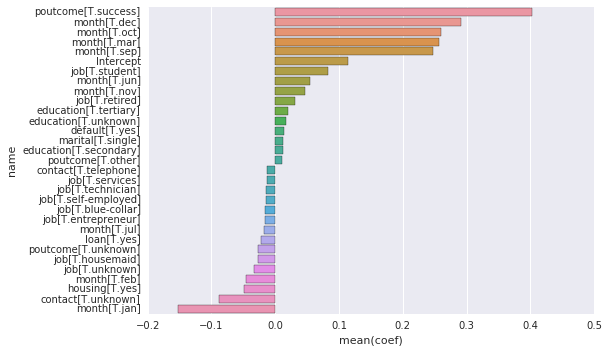

In [12]:
coef['name'] = coef.index.values
sns.barplot(x="coef", y="name", data=coef)

- 3,9,10,12月は正の相関、1,5,8,11月は負の相関
- 前回のキャンペーンの成果は強い正の相関
- job.student, retiredは正の相関
- 連絡方法が不明の人は負の相関（contact.unknown）

月によってかなり申込確率が違うようだ。
詳しく分析してみよう。

## 月ごとの分析

In [13]:
full_count = full[['month', 'id']].groupby(['month']).agg('count')
full_count.columns = ['count']

y_data = train[['month', 'y']].groupby(['month']).agg(['sum', 'mean'])
y_data.columns = ['y_sum', 'y_mean']

month_df = pd.concat([full_count, y_data], axis=1).sort_values(by=['count'], ascending=False)
month_df

,count,y_sum,y_mean
month,,,
may,13766,566,0.068053
jul,6895,376,0.090909
aug,6247,425,0.114309
jun,5341,324,0.101124
nov,3970,235,0.100342
apr,2932,337,0.192023
feb,2649,258,0.162673
jan,1403,84,0.099291
oct,738,192,0.437358


5月のデータがやたら多い

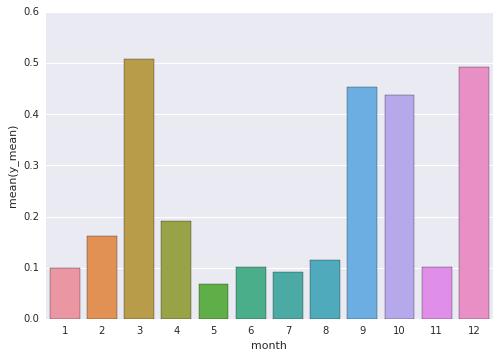

In [14]:
def str2month(str): # str = 'mar' return 3
    return int(datetime.datetime.strptime("{}".format(str), '%b').date().strftime('%m'))

month_df['month'] = np.vectorize(str2month)(month_df.index.values)
sns.barplot(x="month", y="y_mean", data=month_df)

- 3,9,10,12月は申込確率が高い。これはLasso回帰の結果と一致している。
- 5月が申込確率が低い。

## 曜日ごとの分析

In [17]:
full_count = full[['dayofweek', 'id']].groupby(['dayofweek']).agg('count')
full_count.columns = ['count']

y_data = train[['dayofweek', 'y']].groupby(['dayofweek']).agg(['sum', 'mean'])
y_data.columns = ['y_sum', 'y_mean']

day_df = pd.concat([full_count, y_data], axis=1).sort_values(by=['count'], ascending=False)
day_df

,count,y_sum,y_mean
dayofweek,,,
1,9493,689,0.120920
0,8895,638,0.118676
2,8647,455,0.088763
6,8156,605,0.122992
3,5394,177,0.054816
5,4064,474,0.194024
4,562,136,0.403561


思ったより曜日ごとに偏りがある。

曜日番号4は、サンプルは少ないが申込確率は非常に高い。

## 職業ごとに分析

In [15]:
count = full[['job', 'id']].groupby(['job']).agg('count')
count.columns = ['count']
pd.concat([count, full.groupby(['job']).agg('mean')], axis=1).sort_values(by=['count'], ascending=False)

,count,age,balance,campaign,day,dayofweek,dayofyear,duration,id,pdays,previous,y
job,,,,,,,,,,,,
blue-collar,9732,40.044081,1078.826654,2.816995,15.442561,2.504624,158.553843,262.901562,11872.483354,44.033498,0.505138,0.073055
management,9458,40.449567,1763.616832,2.864348,16.114189,2.518080,183.048953,253.995771,11698.668852,38.665468,0.668006,0.136477
technician,7597,39.314598,1252.632092,2.906805,16.408582,2.539160,178.007240,252.904962,11749.311834,37.195077,0.574569,0.106435
admin.,5171,39.289886,1135.838909,2.575324,15.564301,2.565461,163.976987,246.896732,11633.187778,47.859021,0.671630,0.124797
services,4154,38.740250,997.088108,2.718344,15.635532,2.517092,161.639865,259.318729,11744.474001,41.995185,0.501204,0.089385
retired,2264,61.626767,1984.215106,2.346731,15.439488,2.613958,178.924912,287.361307,11723.926237,37.443905,0.638693,0.223580
self-employed,1579,40.484484,1647.970868,2.853072,16.027866,2.411020,181.693477,268.157061,11803.725142,34.747308,0.551615,0.123810
entrepreneur,1487,42.190989,1521.470074,2.799597,15.702085,2.440484,181.121722,256.309348,11948.172831,32.486214,0.478144,0.087527
unemployed,1303,40.961627,1521.745971,2.432080,15.498081,2.495012,154.088258,288.543361,11664.489639,34.146585,0.466616,0.164557


ちょっと情報が多い...。面白そうな相関があるものに絞る。

In [16]:
full[['job', 'y', 'age', 'balance','previous']].groupby(['job']).agg('mean')

,y,age,balance,previous
job,,,,
admin.,0.124797,39.289886,1135.838909,0.671630
blue-collar,0.073055,40.044081,1078.826654,0.505138
entrepreneur,0.087527,42.190989,1521.470074,0.478144
housemaid,0.088889,46.415323,1392.395161,0.371774
management,0.136477,40.449567,1763.616832,0.668006
retired,0.223580,61.626767,1984.215106,0.638693
self-employed,0.123810,40.484484,1647.970868,0.551615
services,0.089385,38.740250,997.088108,0.501204
student,0.298025,26.542644,1388.060768,0.953092


- 申込確率はstudent, retiredが高い。
- 年齢はretiredが高く、studentは若い。
- 口座残高はretiredが多く、servicesが少ない。
  - studentは意外と多い。
- 接触回数はstudentが多い。
  - 銀行側もstudentが申込確率が高いと知っているのだろう。